<a href="https://colab.research.google.com/github/tneum359/Inference-Time-Scaling-for-3D-Diffusion/blob/main/Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !git clone https://github.com/tyluann/SAUCD.git
# !git clone https://github.com/TencentARC/InstantMesh.git
# !git clone https://github.com/Kiord/mesh_align.git

# !pip install torch
# !pip install open3D
# !pip install trimesh
# !pip install numpy
!pip install pyrender
!pip install matplotlib
!pip install scipy
!pip install pyglet
!pip install lpips
!pip install pillow
!pip install scikit-image
!pip install tqdm
!pip install click
!pip install pyvista

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 34.4 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745193 sha256=352cb841f3315c97f5a0bf5cabd68449933bb7ce2d776044688e20e1b7394814
  Stored in directory: /root/.cache/pip/wheels/2f/37/f5/f88cd3dddf75bc3ce608e44bf8a79078c408bf1f351a50818e
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.9
    Uninstalling PyOpenGL-3.1.9:
      Successfully uninstalled PyOpenGL-3.1.9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 24.7 MB/s eta 0:00:00


In [ ]:
#@title Installs
import sys
import torch
import torch.nn.functional as F
import numpy as np
import trimesh
from scipy.spatial import cKDTree
import pyrender
import os
import pyglet
import matplotlib.pyplot as plt
import torchvision.transforms as T
import lpips
from PIL import Image

from pathlib import Path

pyglet.options['debug_lib'] = False
pyglet.options['debug_gl'] = False
sys.path.append('/content/InstantMesh/src/utils')
sys.path.append('/content/mesh_align')

# from camera_util import*
# from mesh_align import align_meshes


We clone different metric repositories, including SAUCD which is a more human-aligned method for 3D shape evaluation

Our first metric is the chamfer distance. If you have two 3D shapes represented by sets of points (A and B), the Chamfer Distance is:

For each point in A, find the closest point in B and compute the distance.

Do the same in reverse (each point in B to closest in A).

Average both sets of distances


In [ ]:
#@title Load Meshes
output_dir = '/content/drive/MyDrive/2024-2025/6.S058/final_project/Metric_Outputs'
# mesh_path1 = '/content/drive/MyDrive/2024-2025/6.S058/final_project/input_3d/000-084/91fd7aae5bbd4519b4c13ad8a94260cd.glb'
# mesh_path2 = '/content/drive/MyDrive/2024-2025/6.S058/final_project/output_3d/test.obj'
# mesh_path3 = mesh_path1
mesh_path1 = '/content/drive/MyDrive/2024-2025/6.S058/final_project/input_3d/glb_batch_2/0114.glb'
mesh_path2 = '/content/drive/MyDrive/2024-2025/6.S058/final_project/output_3d/output_0114/obj_no_gemini.obj'
mesh_path3 = '/content/drive/MyDrive/2024-2025/6.S058/final_project/output_3d/output_0114/obj_with_gemini.obj'

import trimesh as tm

def scene_to_mesh(scene):
    if isinstance(scene, trimesh.Scene):
        mesh = trimesh.util.concatenate(tuple(scene.geometry.values()))
    elif isinstance(scene, trimesh.Trimesh):
        mesh = scene
    else:
        raise TypeError(f"Object of type {type(scene)} not recognized")
    return mesh

def get_data(mesh_path):
    """Load a mesh with UVs & texture intact."""
    mesh = tm.load(mesh_path, process=False, force='mesh')  # <- no Scene, no concat
    return mesh

def load_scene(path: str | Path) -> tm.Scene:
    """Return the Scene unchanged (all sub‑meshes + textures intact)."""
    file_type = os.path.splitext(path)[1][1:].lower()  # Get extension and make lowercase

    return tm.load(path, file_type=file_type, process=False) #add file type

In [ ]:
#@title Align Meshes
"""Mesh alignment utilities for Colab
-------------------------------------------------
This module provides:
  * `canonicalize`  – centres, scales to [-1,1]^3, aligns PCA axes.
  * `axis_permutation_matrices` – 24 proper axis‑aligned rotations (+ optional reflections).
  * `icp`           – rigid or similarity ICP with optional rotation/reflection search.
  * `align_meshes`  – convenience wrapper that performs
        1. canonicalisation (locks scale)
        2. coarse ICP across all axis‑aligned rotations
        3. fine ICP
  * Example usage at the bottom (works in Google Colab).

Dependencies: trimesh, numpy, scipy, tqdm, pyvista (optional for plotting).
Install with:
    !pip install trimesh pyvista scipy tqdm
"""

from __future__ import annotations
import numpy as np
import trimesh as tm
from itertools import permutations, product
from tqdm import tqdm
from scipy.spatial import cKDTree
from trimesh.registration import procrustes
from typing import List, Tuple, Optional

# ───────────────────────────────────────────────────────────────────────────────
# 1.  Canonicalisation – put mesh inside [-1,1]^3 and align PCA axes
# ───────────────────────────────────────────────────────────────────────────────

def canonicalize(mesh: tm.Trimesh, target_range: float = 2.0) -> np.ndarray:
    """Translate → scale → rotate so that *mesh* ends up in [-1,1]^3.

    Returns the 4×4 transform that *was applied* (original → canonical).
    """
    # ── centre at origin ───────────────────────────────────────────────────────
    T = np.eye(4)
    T[:3, 3] = -mesh.centroid
    mesh.apply_transform(T)

    # ── uniform scale to fit cube ─────────────────────────────────────────────
    max_extent = np.max(mesh.extents)  # longest side of AABB
    s = target_range / max_extent      # after scaling, longest side = 2
    S = np.diag([s, s, s, 1.0])
    mesh.apply_transform(S)

    # ── align principal components (PCA) ──────────────────────────────────────
    verts = mesh.vertices
    cov = np.cov(verts.T)
    _, V = np.linalg.eigh(cov)         # columns are eigenvectors
    R = V[:, ::-1]                     # largest eigen‑vector → +X …

    # fix handedness to keep a proper rotation
    if np.linalg.det(R) < 0:
        R[:, 0] *= -1
    R4 = np.eye(4)
    R4[:3, :3] = R
    mesh.apply_transform(R4)

    return R4 @ S @ T

# ───────────────────────────────────────────────────────────────────────────────
# 2.  Enumerate axis‑aligned rotations / reflections
# ───────────────────────────────────────────────────────────────────────────────

def axis_permutation_matrices(test_reflections: bool = True) -> List[np.ndarray]:
    """Return list of 24 proper (or 48 incl. reflections) 4×4 rotation matrices."""
    mats = []
    for perm in permutations(range(3)):
        for signs in product([-1, 1], repeat=3):
            R3 = np.zeros((3, 3))
            for i, ax in enumerate(perm):
                R3[i, ax] = signs[i]
            if not test_reflections and np.linalg.det(R3) < 0:
                continue  # skip improper rotations
                print("no reflections")
            M = np.eye(4)
            M[:3, :3] = R3
            mats.append(M)
    return mats

# # convenience wrapper for reflections only (rarely needed)
# _get_reflections = lambda: axis_permutation_matrices(test_reflections=True)

# ───────────────────────────────────────────────────────────────────────────────
# 3.  Iterative Closest Point (rigid or similarity)
# ───────────────────────────────────────────────────────────────────────────────

def icp(
    source_mesh: tm.Trimesh | tm.PointCloud,
    target_mesh: tm.Trimesh | tm.PointCloud,
    n_iter: int = 100,
    count_source: int = 10_000,
    count_target: int = 20_000,
    initial_transforms: Optional[List[np.ndarray]] = None,
    fixed_scale: bool = True,
    outliers: float = 0.0,
    on_surface: bool = False,
    min_scale: float = 0.5,
    max_scale: float = 2.0,
) -> Tuple[np.ndarray, float]:
    """Rigid / similarity ICP.  Returns (best_transform, best_cost)."""

    # sample points -----------------------------------------------------------
    if isinstance(source_mesh, tm.PointCloud):
        source_pts = source_mesh.vertices
    else:
        source_pts = tm.sample.sample_surface_even(source_mesh, count_source)[0]

    if isinstance(target_mesh, tm.PointCloud):
        target_pts = target_mesh.vertices
    else:
        target_pts = tm.sample.sample_surface_even(target_mesh, count_target)[0]

    kdtree = cKDTree(target_pts)
    n_out = int(outliers * len(source_pts))

    # default: start from identity only
    if initial_transforms is None:
        initial_transforms = [np.eye(4)]

    best_global_cost = np.inf
    best_global_T = np.eye(4)

    for T0 in initial_transforms:
        T = T0.copy()
        best_local_cost = np.inf

        for _ in range(n_iter):
            p = tm.transform_points(source_pts, T)

            if on_surface:
                q, dists = tm.proximity.closest_point(target_mesh, p)[:2]
            else:
                dists, idx = kdtree.query(p)
                q = target_pts[idx]

            # reject farthest outliers ---------------------------------------
            if n_out > 0:
                order = np.argsort(dists)
                keep = order[:-n_out]
                p_in, q_in = p[keep], q[keep]
                cost = dists[keep].mean()
            else:
                p_in, q_in = p, q
                cost = dists.mean()

            # Procrustes (rigid or similarity) -------------------------------
            T_step = procrustes(p_in, q_in, reflection=False, return_cost=False, scale=not fixed_scale)
            T = T_step @ T

            if not fixed_scale:
                s_current = np.linalg.norm(T[:3, 0])
                s_clamped = np.clip(s_current, min_scale, max_scale)
                T[:3, :3] *= s_clamped / s_current

            if cost < best_local_cost:
                best_local_cost = cost

        # track global best over initial transforms -------------------------
        if best_local_cost < best_global_cost:
            best_global_cost = best_local_cost
            best_global_T = T.copy()

    return best_global_T, best_global_cost

# ───────────────────────────────────────────────────────────────────────────────
# 4.  High‑level helper
# ───────────────────────────────────────────────────────────────────────────────

def align_meshes(
    source_mesh: tm.Trimesh,
    target_mesh: tm.Trimesh,
    coarse_iter: int = 150,
    fine_iter: int = 100,
    outliers: float = 0.1,
    plot: bool = False,
    test_reflections: bool = True,
) -> Tuple[tm.Trimesh, np.ndarray]:
    """Return (aligned_source_copy, 4×4 total_transform)."""

    src = source_mesh.copy()
    tgt = target_mesh.copy()

    if isinstance(src, tm.Scene):
        src = tm.util.concatenate(tuple(source_mesh.geometry.values()))
        src.area_faces # calculate the face area
    if isinstance(tgt, tm.Scene):
        tgt = tm.util.concatenate(tuple(target_mesh.geometry.values()))
        tgt.area_faces # calculate the face area

    # ---- 1. canonicalise both (locks scale) -------------------------------
    T_src_canon = canonicalize(src)
    T_tgt_canon = canonicalize(tgt)

    # ---- 2. coarse ICP over 24 rotations ----------------------------------
    R_candidates = axis_permutation_matrices(test_reflections=test_reflections)
    T_coarse, _ = icp(
        src, tgt,
        n_iter=coarse_iter,
        count_source=1_000, count_target=5_000,
        initial_transforms=R_candidates,
        fixed_scale=True,
        outliers=outliers,
    )
    src.apply_transform(T_coarse)

    # ---- 3. fine ICP -------------------------------------------------------
    T_fine, _ = icp(
        src, tgt,
        n_iter=fine_iter,
        count_source=10_000, count_target=20_000,
        fixed_scale=True,
        outliers=outliers / 2,
    )
    src.apply_transform(T_fine)

    # full chain: original‑src → canonical → coarse → fine
    T_total = T_fine @ T_coarse @ T_src_canon

                  # now same cube as m2_aligned


    return src, tgt, T_total

def align_objects(src_obj: tm.Scene | tm.Trimesh,
                  tgt_obj: tm.Scene | tm.Trimesh,
                  **icp_kwargs):
    # --- build ICP inputs --------------------------------------------------
    if isinstance(src_obj, tm.Scene):
        src_icp = tm.util.concatenate(tuple(g.copy() for g in src_obj.geometry.values()))
    else:  # already a Trimesh
        src_icp = src_obj.copy()

    if isinstance(tgt_obj, tm.Scene):
        tgt_icp = tm.util.concatenate(tuple(g.copy() for g in tgt_obj.geometry.values()))
    else:
        tgt_icp = tgt_obj.copy()

    # --- your existing ICP pipeline (canonicalise + coarse + fine) ---------
    _, tgt_aligned, T_total, = align_meshes(src_icp, tgt_icp, **icp_kwargs)  # reuse previous code

    # --- apply transform in‑place to a *copy* of the ORIGINAL --------------
    src_aligned = src_obj
    if isinstance(src_aligned, tm.Scene):
        for g in src_aligned.geometry.values():
            g.apply_transform(T_total)
    else:  # Trimesh
        src_aligned.apply_transform(T_total)

    return src_aligned, tgt_aligned, T_total




def load_meshes(paths):
  meshes = []
  for path in paths:
    mesh = load_scene(path)
    meshes.append(mesh)

  return meshes
# ───────────────────────────────────────────────────────────────────────────────
# 5.  Example usage (Colab cell)
# ───────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    import pathlib, os



    mesh1, mesh2, mesh3 = load_meshes([mesh_path1, mesh_path2, mesh_path3])


    mesh2_aligned, mesh1_aligned, T = align_objects(mesh2, mesh1, test_reflections=True )
    mesh3_aligned, _, T = align_objects(mesh3, mesh1, test_reflections=True )




In [ ]:
#@title Calculate Chamfer Distance

def chamfer_distance_trimesh(mesh_a, mesh_b, num_samples=16000):
    """
    Compute symmetric Chamfer Distance between two trimesh.Trimesh meshes.

    Parameters:
        mesh_a (trimesh.Trimesh): First mesh
        mesh_b (trimesh.Trimesh): Second mesh
        num_samples (int): Number of surface samples per mesh

    Returns:
        float: Chamfer distance (symmetric, L2-squared)
    """
    # Sample points from mesh surfaces
    points_a = mesh_a.sample(num_samples)
    points_b = mesh_b.sample(num_samples)

    # Build KD trees
    tree_b = cKDTree(points_b)
    tree_a = cKDTree(points_a)

    # Nearest neighbor distances
    dists_a_to_b, _ = tree_b.query(points_a)
    dists_b_to_a, _ = tree_a.query(points_b)

    # Chamfer distance = average squared distances both ways
    chamfer = np.mean(dists_a_to_b) + np.mean(dists_b_to_a)
    return chamfer


# Calculate Chamfer distance
print("Chamfer Distance between mesh1 and mesh2:", chamfer_distance_trimesh(mesh1_aligned, mesh2_aligned))
print("Chamfer Distance between mesh1 and mesh2:", chamfer_distance_trimesh(mesh2_aligned, mesh1_aligned))

print("Chamfer Distance between mesh1 and mesh3:", chamfer_distance_trimesh(mesh1_aligned, mesh3_aligned))
print(len(mesh1_aligned.vertices), len(mesh2_aligned.vertices))
print(len(mesh1_aligned.vertices), len(mesh3_aligned.vertices))


Chamfer Distance between mesh1 and mesh2: 0.04995447458400574
Chamfer Distance between mesh1 and mesh2: 0.049249120429279244
Chamfer Distance between mesh1 and mesh3: 0.051624483789359764
16706 11212
16706 8660


In [ ]:
#@title Visualize Alignment
import numpy as np
import plotly.graph_objects as go

def display_meshes(meshes, colours, opacity=1.0):
    """
    meshes   : list[trimesh.Trimesh]
    colours  : list[str | tuple]  e.g. ['red', 'green'] or [(255,0,0), (0,255,0)]
    opacity  : float in [0,1]
    """
    if len(meshes) != len(colours):
        raise ValueError("`meshes` and `colours` must have the same length.")

    fig = go.Figure()

    for mesh, colour in zip(meshes, colours):
        v = np.asarray(mesh.vertices)
        f = np.asarray(mesh.faces)

        # If you want a *single* colour per mesh, just pass `color=…`
        # (Vertex colours are only needed for per‑vertex gradients.)
        fig.add_trace(
            go.Mesh3d(
                x=v[:, 0], y=v[:, 1], z=v[:, 2],
                i=f[:, 0], j=f[:, 1], k=f[:, 2],
                color=colour,
                opacity=opacity,
                flatshading=True,
            )
        )

    fig.update_layout(
        scene=dict(
            aspectmode='data',
            camera=dict(
                up=dict(x=0, y=1, z=0),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        margin=dict(l=0, r=0, t=0, b=0),
        showlegend=False
    )
    fig.show()
# give each mesh a name you align with the colour list
# meshes  = [mesh1_aligned, ]
meshes = [ mesh3_aligned, ]
# colours = ['red',  'limegreen', 'blue']
colours = ['blue']          # or ('rgb(255,0,0)', 'rgb(0,255,0)')
#
display_meshes(meshes, colours, opacity=0.3)

Now we can load our 2D metrics, begin

In [ ]:
#@title Load 2D Views
# ---------- view_generator_trimesh.py ----------
"""
Render uniformly distributed views of a *trimesh* object.

Dependencies
------------
pip install trimesh pyvista
"""
from __future__ import annotations
import os
from pathlib import Path
from typing import Sequence
from copy import deepcopy
import pyvista as pv


# --------------------------------------------------------------------- #
#  Helpers
# --------------------------------------------------------------------- #
def _get_texture_image(material):
    """
    Handle both SimpleMaterial and PBRMaterial, return uint8 array (H,W,3/4).
    """
    if isinstance(material, tm.visual.material.PBRMaterial):
        tex = material.baseColorTexture
        img = tex if tex is not None else None
    else:                          # SimpleMaterial
        img = material.image
    if hasattr(img, "to_numpy"):   # PIL.Image from glTF
        img = img.to_numpy()
    return np.asarray(img, dtype=np.uint8)
def _trimesh_to_pv_and_texture(mesh: tm.Trimesh):
    """
    Return (pv_mesh, texture_or_None) with everything PyVista needs.
    """
    faces = np.column_stack(
        [np.full((mesh.faces.shape[0], 1), 3, dtype=np.int64),
         mesh.faces.astype(np.int64)]
    ).ravel()
    pv_mesh = pv.PolyData(mesh.vertices, faces)

    # ----------  UV‑TEXTURED MESH  --------------------------------------
    if mesh.visual.kind == "texture":
        # ----- flatten (pos, uv, idx) so each corner is unique ----------
        #   OBJ face like v1/vt7  v1/vt8  v2/vt3  →
        #   three *distinct* vertices in PyVista
        corner_pos = mesh.vertices[mesh.faces].reshape(-1, 3)
        corner_uv  = mesh.visual.uv[mesh.faces].reshape(-1, 2)

        # build new face index list: [3,0,1,2, 3,3,4,5, ...]
        n_faces = mesh.faces.shape[0]
        corner_idx = np.arange(n_faces * 3, dtype=np.int64)
        faces = np.column_stack(
            (np.full((n_faces, 1), 3, dtype=np.int64),
             corner_idx.reshape(-1, 3))
        ).ravel()

        pv_mesh = pv.PolyData(corner_pos, faces)
        pv_mesh.active_t_coords = corner_uv

        # make the texture
        tex_img = _get_texture_image(mesh.visual.material)   # helper below
        texture = pv.numpy_to_texture(tex_img)
        texture.repeat = True                                # wrap, not clamp
        return pv_mesh, texture

    # ----------  VERTEX‑COLOUR MESH  -----------------------------------
    if mesh.visual.kind == "vertex":
        print(f'using vertex')
        colors = mesh.visual.vertex_colors[:, :4]   # RGBA uint8
        pv_mesh.point_data["Colors"] = colors
        return pv_mesh, None

    # ----------  NO  COLOUR  -------------------------------------------
    print(f'no color found')
    return pv_mesh, None

def _fibonacci_sphere(n: int) -> np.ndarray:
    """Evenly spaced directions on the unit sphere (n, 3)."""
    idx      = np.arange(n)
    phi      = 2.0 * np.pi * idx / ((1 + np.sqrt(5)) / 2)     # golden‑angle
    cos_t    = 1.0 - 2.0 * (idx + 0.5) / n
    sin_t    = np.sqrt(1.0 - cos_t**2)
    return np.stack([np.cos(phi) * sin_t,
                     np.sin(phi) * sin_t,
                     cos_t], axis=1)



# --------------------------------------------------------------------- #
#  Core rendering
# --------------------------------------------------------------------- #
def generate_views_for_trimesh(
    mesh: tm.Trimesh,
    mesh_name: str,
    n_views: int = 32,
    output_root: str | Path = ".",
    mesh_path: str | Path = ".",
    distance_factor: float = 4.0,
    img_size: tuple[int, int] = (256, 256)
) -> None:
    """
    Render *n_views* screenshots of `mesh`.

    Results are stored under `<output_root>/<mesh_name>/<mesh_name>_{00‑31}.png`.
    """
    # Colab / headless safety
    os.environ.setdefault("PYVISTA_OFF_SCREEN", "true")

    output_root = os.path.join(output_root, Path(mesh_path1).stem)
    out_dir = Path(output_root)
    out_dir.mkdir(parents=True, exist_ok=True)


    # Centering & scale
    center  = mesh.centroid
    radius  = np.linalg.norm(mesh.vertices - center, axis=1).max()

    pv_mesh, texture = _trimesh_to_pv_and_texture(mesh)
    pl = pv.Plotter(off_screen=True, window_size=img_size)

    if texture is not None:                               # UV‑textured mesh
        pl.add_mesh(pv_mesh,
                    texture=texture,
                    smooth_shading=True)

    elif "Colors" in pv_mesh.point_data:                  # vertex colours
        pl.add_mesh(pv_mesh,
                    scalars="Colors",
                    rgb=True,
                    smooth_shading=True)

    else:                                                 # plain grey mesh
        pl.add_mesh(pv_mesh, smooth_shading=True)




    up_global = np.array([0, 0, 1.0])
    for i, vec in enumerate(_fibonacci_sphere(n_views)):
        pl.camera.position = center + vec * radius * distance_factor
        pl.camera.focal_point = center
        pl.camera.up = up_global if abs(vec @ up_global) < 0.95 else np.array([0, 1, 0])
        pl.camera.clipping_range = (0.01 * radius, 10.0 * radius)

        pl.show(auto_close=False)
        img_path = out_dir / f"{mesh_name}_{i:02d}.png"
        pl.screenshot(str(img_path))
    pl.close()

    print(f"✓  {n_views} views saved to {out_dir}")


# --------------------------------------------------------------------- #
#  Convenience multi‑mesh wrapper
# --------------------------------------------------------------------- #
def generate_views_batch(
    meshes: Sequence[tuple[str, tm.Trimesh]],
    n_views: int = 32,
    output_root: str | Path = ".",
    mesh_path: str | Path = ".",
    **kwargs
) -> None:
    """
    Render many meshes at once.

    Parameters
    ----------
    meshes : sequence of (name, trimesh.Trimesh)
        Each `(name, mesh)` pair becomes its own sub‑folder.
    n_views : int
        How many camera positions to render for each mesh.
    output_root : str | Path
        Parent directory where sub‑folders are created.
    kwargs : dict
        Additional keyword arguments forwarded to `generate_views_for_trimesh`
        (e.g., `distance_factor`, `img_size`).
    """
    for mesh, name in meshes:

        generate_views_for_trimesh(mesh, name, n_views, output_root, mesh_path, **kwargs)


meshes = [(mesh1_aligned, "ground_truth",), (mesh2_aligned, "no_gemini",), (mesh3_aligned, "with_gemini", )]
output_root = '/content/drive/MyDrive/2024-2025/6.S058/final_project/2d_output'
generate_views_batch(meshes, n_views = 32, output_root=output_root, mesh_path = mesh_path1)



✓  32 views saved to /content/drive/MyDrive/2024-2025/6.S058/final_project/2d_output/0003
using vertex
✓  32 views saved to /content/drive/MyDrive/2024-2025/6.S058/final_project/2d_output/0003
using vertex
✓  32 views saved to /content/drive/MyDrive/2024-2025/6.S058/final_project/2d_output/0003


Here we can generate input images from ground truth meshes to input into out model


In [ ]:
#@title Generate Input Images
input_photos = '/content/drive/MyDrive/2024-2025/6.S058/final_project/input_images'

def get_object_radius(mesh, scale=1.5):
    bbox = mesh.bounds  # [[min_x, min_y, min_z], [max_x, max_y, max_z]]
    center = (bbox[0] + bbox[1]) / 2
    extent = np.linalg.norm(bbox[1] - bbox[0])  # diagonal length
    return extent * scale, torch.tensor(center, dtype=torch.float32)

def get_front_camera_pose(radius=2.5, look_at=None, up=None):
    cam_pos = torch.tensor([0, 0, radius], dtype=torch.float32)
    look_at = torch.tensor([0, 0, 0], dtype=torch.float32) if look_at is None else look_at.float()
    up = torch.tensor([0, 0, 1], dtype=torch.float32) if up is None else up.float()
    extrinsics = center_looking_at_camera_pose(cam_pos, look_at=look_at, up_world=up)
    return extrinsics

def render(mesh, extrinsic, output_dir=input_photos, fov=45.0, radius=20):

    os.makedirs(output_dir, exist_ok=True)
    os.environ['PYOPENGL_PLATFORM'] = 'egl'


    # extrinsics = get_front_camera_pose(radius=radius)
    image = render_mesh_with_camera(mesh, extrinsic, fov=fov)
    fname = f"mesh_origin.png"
    path = os.path.join(output_dir, fname)
    plt.imsave(path, image)


radius, center = get_object_radius(mesh1)
center_extrensics = get_front_camera_pose(radius=radius, look_at=center)
# center_extrensics = get_front_camera_pose(radius=10)
render(mesh1, center_extrensics)



NameError: name 'center_looking_at_camera_pose' is not defined

Now that we have generated our 2D views, we can evaluate them with image metrics


In [ ]:
#@title Calculate 2D Metrics
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
# LPIPS model setup
lpips_model = lpips.LPIPS(net='alex')  # Can use 'alex', 'vgg', 'squeeze'
lpips_model.eval()

# Helper: Convert PIL or numpy image to normalized torch tensor
def image_to_tensor(image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] for LPIPS
    ])
    return transform(image).unsqueeze(0)

# Main comparison function
def compute_metrics(pred_img, gt_img):
    # Ensure both are PIL Images
    if isinstance(pred_img, np.ndarray):
        pred_img = Image.fromarray(pred_img)
    if isinstance(gt_img, np.ndarray):
        gt_img = Image.fromarray(gt_img)

    # PSNR and SSIM use images in [0, 255]
    pred_np = np.array(pred_img.resize((256, 256)))
    gt_np = np.array(gt_img.resize((256, 256)))

    psnr = compute_psnr(gt_np, pred_np, data_range=255)
    ssim = compute_ssim(gt_np, pred_np, data_range=255, channel_axis=-1)

    # LPIPS uses torch tensors normalized to [-1, 1]
    pred_tensor = image_to_tensor(pred_img)
    gt_tensor = image_to_tensor(gt_img)
    lpips_value = lpips_model(pred_tensor, gt_tensor).item()

    return psnr, ssim, lpips_value

def get_metric_dict_for_views(view_dict):

  metrics = {} #a dictionary where key = views and values are {psnr, ssim, lpips}
  for view in view_dict.keys():
    view_metrics = compute_metrics(view_dict[view][0], view_dict[view][1])
    metrics[view] = view_metrics
  return metrics


#########CALL FUNCTIONS######
base_metrics = get_metric_dict_for_views(views_base)
time_scaled_metrics = get_metric_dict_for_views(views_time_scaled)
# print(f'{metrics=}')
# print(f'{len(views)=}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 105MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


AttributeError: 'numpy.ndarray' object has no attribute 'Compose'

Now we will plot our findings

In [ ]:
#@title Plot Findings
cd_base = chamfer_distance(mesh1, mesh2_aligned)
cd_time_scaled = chamfer_distance(mesh1, mesh2_aligned)
models = ['Base Model', 'Inference-Timed_Scaled_Model']
cd_values = [cd_base, cd_time_scaled]

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(models, cd_values, color=['#4C72B0', '#55A868'], width=0.5)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.0001,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Styling
plt.ylabel('Chamfer Distance (↓)', fontsize=12)
plt.title('Chamfer Distance Comparison', fontsize=14, weight='bold')
plt.ylim(0, max(cd_values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Save for paper
plt.savefig("chamfer_comparison.png", dpi=300)
plt.show()

AttributeError: 'Trimesh' object has no attribute 'sample_points_poisson_disk'

Now we visualize the 2D metrics


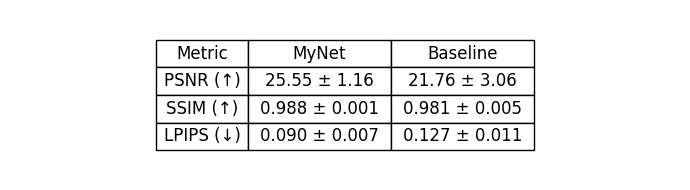

In [ ]:
#@title Visualize 2D
import pandas as pd

def summarize_metrics(metrics_dict):
    # Check if values are tuples or dicts
    sample_val = next(iter(metrics_dict.values()))

    if isinstance(sample_val, dict):
        psnr_vals = [v['psnr'] for v in metrics_dict.values()]
        ssim_vals = [v['ssim'] for v in metrics_dict.values()]
        lpips_vals = [v['lpips'] for v in metrics_dict.values()]
    elif isinstance(sample_val, (tuple, list)) and len(sample_val) == 3:
        psnr_vals = [v[0] for v in metrics_dict.values()]
        ssim_vals = [v[1] for v in metrics_dict.values()]
        lpips_vals = [v[2] for v in metrics_dict.values()]
    else:
        raise ValueError("Each value must be either a dict with keys 'psnr', 'ssim', 'lpips' or a tuple/list of length 3.")

    return {
        'psnr': (np.mean(psnr_vals), np.std(psnr_vals)),
        'ssim': (np.mean(ssim_vals), np.std(ssim_vals)),
        'lpips': (np.mean(lpips_vals), np.std(lpips_vals))
    }

def make_metrics_table(model_a_dict, model_b_dict, model_a_label="Model A", model_b_label="Model B"):
    a_summary = summarize_metrics(model_a_dict)
    b_summary = summarize_metrics(model_b_dict)

    # Build table
    data = {
        'Metric': ['PSNR (↑)', 'SSIM (↑)', 'LPIPS (↓)'],
        model_a_label: [
            f"{a_summary['psnr'][0]:.2f} ± {a_summary['psnr'][1]:.2f}",
            f"{a_summary['ssim'][0]:.3f} ± {a_summary['ssim'][1]:.3f}",
            f"{a_summary['lpips'][0]:.3f} ± {a_summary['lpips'][1]:.3f}"
        ],
        model_b_label: [
            f"{b_summary['psnr'][0]:.2f} ± {b_summary['psnr'][1]:.2f}",
            f"{b_summary['ssim'][0]:.3f} ± {b_summary['ssim'][1]:.3f}",
            f"{b_summary['lpips'][0]:.3f} ± {b_summary['lpips'][1]:.3f}"
        ]
    }

    df = pd.DataFrame(data)

    # Plot as a clean table
    fig, ax = plt.subplots(figsize=(7, 2))
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    tbl.scale(1, 1.5)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    tbl.auto_set_column_width(col=list(range(len(df.columns))))

    plt.tight_layout()
    plt.show()



  # base_metrics = get_metric_dict_for_views(views)
make_metrics_table(base_metrics, time_scaled_metrics, model_a_label="MyNet", model_b_label="Baseline")


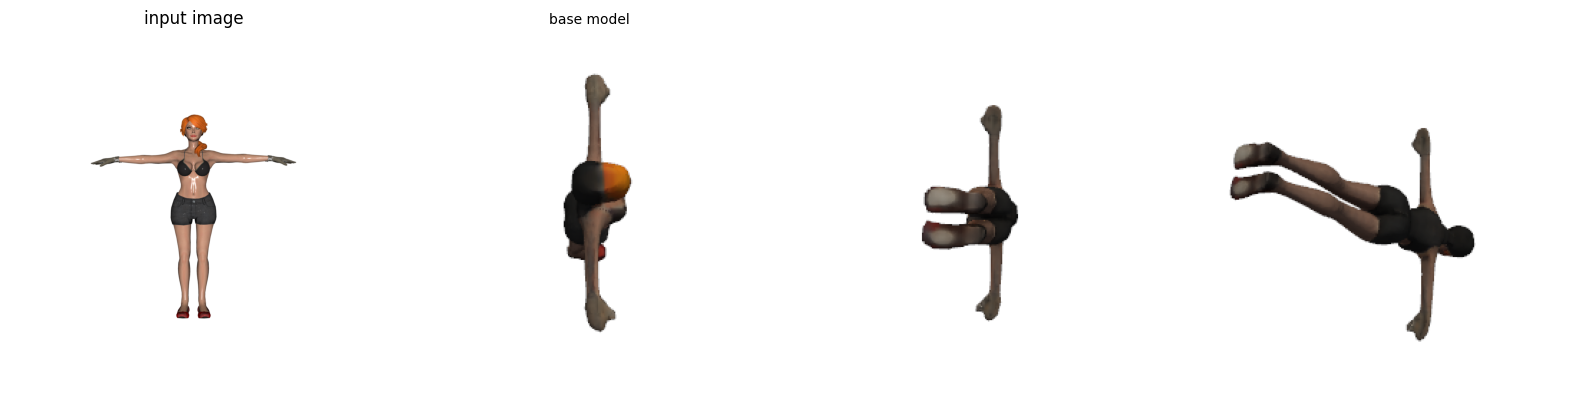

Saved: /content/drive/MyDrive/2024-2025/6.S058/final_project/metric_outputs/0114_no_gemini.png


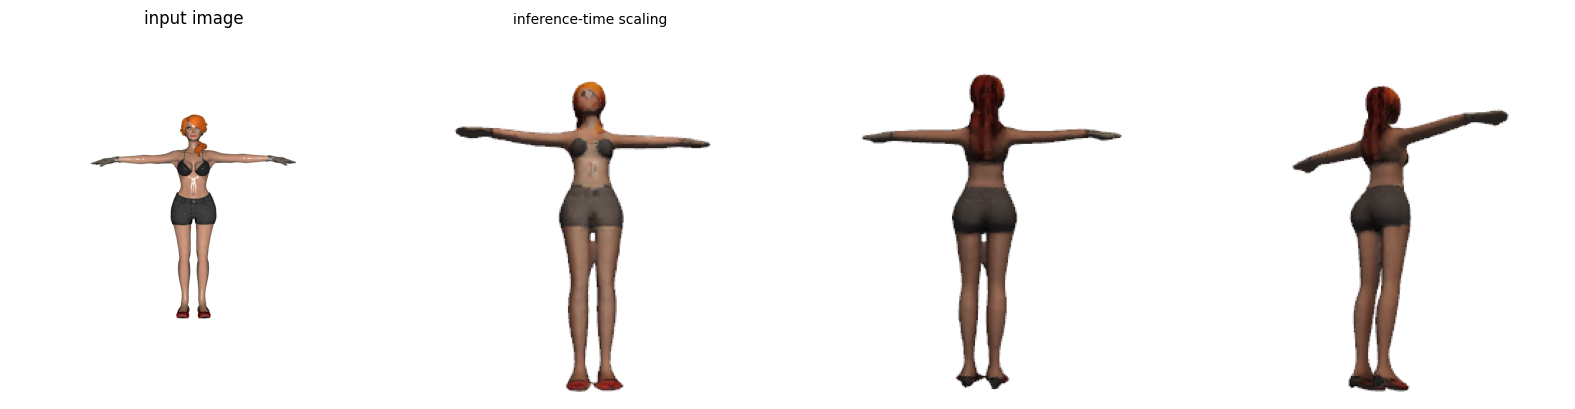

Saved: /content/drive/MyDrive/2024-2025/6.S058/final_project/metric_outputs/0114_with_gemini.png


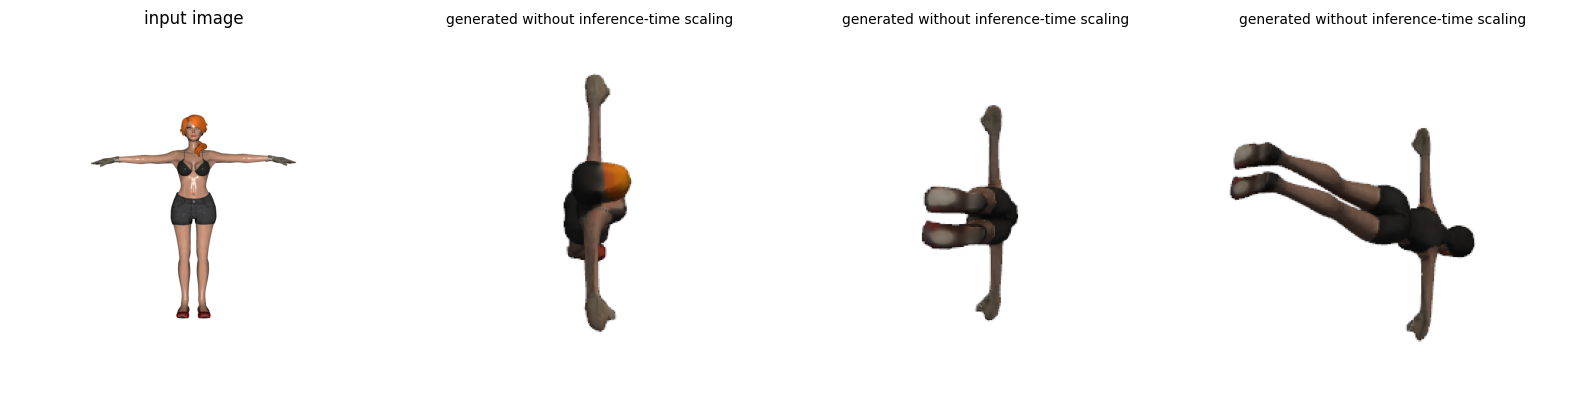

Saved: /content/drive/MyDrive/2024-2025/6.S058/final_project/metric_outputs/0114_no_gemini.png


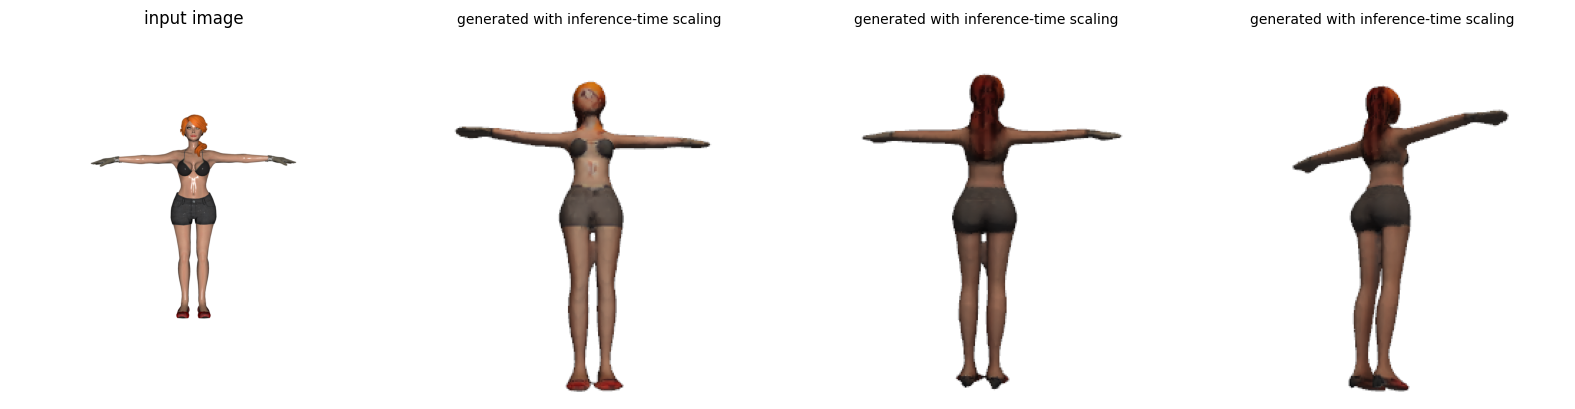

Saved: /content/drive/MyDrive/2024-2025/6.S058/final_project/metric_outputs/0114_with_gemini.png


In [ ]:
#@title Create Figures
input_id_dir = '/content/drive/MyDrive/2024-2025/6.S058/final_project/input_images'
input_id_dir = '/content/drive/MyDrive/2024-2025/6.S058/final_project/input_images'
views_dir = '/content/drive/MyDrive/2024-2025/6.S058/final_project/2d_output'


# id_list = [39, 101, 104, 145, 111, 47, 188, 29, 83, 149, 213, 216]
id_list = [114]
id_list = [str(i).zfill(4) for i in id_list]
views = [19, 15, 20]
views = [str(i).zfill(2) for i in views]

import os
from PIL import Image
import matplotlib.pyplot as plt

# --- User parameters ---
orig_dir   = input_id_dir
gen_dir    = views_dir   # contains subfolders matching orig filenames
folders    = id_list  # example list of folder names
views      = views# your list of view numbers [0,1,...,31]
output_dir = '/content/drive/MyDrive/2024-2025/6.S058/final_project/metric_outputs/'      # where to save the combined plots

os.makedirs(output_dir, exist_ok=True)

def make_composite(folder_name, mode):
    """
    folder_name: name of subfolder (matches original image basename)
    mode: either 'with_gemini' or 'no_gemini'
    """
    # Load original
    orig_path = os.path.join(orig_dir, f"{folder_name}.png")
    orig_img  = Image.open(orig_path).convert('RGB')

    # Prepare subplots: 1 (original) + N views
    ncols = 1 + len(views)
    fig, axes = plt.subplots(1, ncols, figsize=(4 * ncols, 4))

    # Plot original
    ax = axes[0]
    ax.imshow(orig_img)
    ax.axis('off')
    ax.set_title("input image", fontsize=12)

    # Plot each generated view
    for i, v in enumerate(views, start=1):
        view_path = os.path.join(gen_dir, str(folder_name), f"{mode}_{v}.png")
        img = Image.open(view_path).convert('RGB')
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        if i == 1:
          if mode == 'with_gemini':
              label = "inference‑time scaling"
          else:
              label = "base model"

          ax.set_title(label, fontsize=10)

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"{folder_name}_{mode}.png")
    plt.savefig(out_path, dpi=150)
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

# --- Main loop ---
for folder in folders:
    make_composite(folder, mode='no_gemini')
    make_composite(folder, mode='with_gemini')
import os
from PIL import Image
import matplotlib.pyplot as plt

# --- User parameters ---
orig_dir   = input_id_dir
gen_dir    = views_dir   # contains subfolders matching orig filenames
folders    = id_list  # example list of folder names
views      = views# your list of view numbers [0,1,...,31]
output_dir = '/content/drive/MyDrive/2024-2025/6.S058/final_project/metric_outputs/'      # where to save the combined plots

os.makedirs(output_dir, exist_ok=True)

def make_composite(folder_name, mode):
    """
    folder_name: name of subfolder (matches original image basename)
    mode: either 'with_gemini' or 'no_gemini'
    """
    # Load original
    orig_path = os.path.join(orig_dir, f"{folder_name}.png")
    orig_img  = Image.open(orig_path).convert('RGB')

    # Prepare subplots: 1 (original) + N views
    ncols = 1 + len(views)
    fig, axes = plt.subplots(1, ncols, figsize=(4 * ncols, 4))

    # Plot original
    ax = axes[0]
    ax.imshow(orig_img)
    ax.axis('off')
    ax.set_title("input image", fontsize=12)

    # Plot each generated view
    for i, v in enumerate(views, start=1):
        view_path = os.path.join(gen_dir, folder_name, f"{mode}_{v}.png")
        img = Image.open(view_path).convert('RGB')
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        label = ("generated with inference‑time scaling"
                 if mode == 'with_gemini'
                 else "generated without inference‑time scaling")
        ax.set_title(label, fontsize=10)

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"{folder_name}_{mode}.png")
    plt.savefig(out_path, dpi=150)
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

# --- Main loop ---
for folder in folders:
    make_composite(folder, mode='no_gemini')
    make_composite(folder, mode='with_gemini')
